In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import coint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from numpy.random import normal

In [8]:
def plot_heatmap(heatmap_frame):
    
    plt.imshow(heatmap_frame, origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(label='Sharpe')
    plt.xticks(ticks=np.arange(len(heatmap_frame.columns)), labels=[round(x, 2) for x in heatmap_frame.columns], rotation=45)
    plt.yticks(ticks=np.arange(len(heatmap_frame.index)), labels=[round(x, 2) for x in heatmap_frame.index])
    plt.xlabel('Profit Taking')
    plt.ylabel('Stop Loss')
    plt.title('Forecast=0, H-L=5, Sigma=1')
    plt.show()

# Exercises

### 13.1

Suppose you are an execution trader. A client calls you with an order to cover a
short position she entered at a price of 100. She gives you two exit conditions:
profit-taking at 90 and stop-loss at 105.

(a) Assuming the client believes the price follows an O-U process, are these
levels reasonable? For what parameters?

(b) Can you think of an alternative stochastic process under which these levels
make sense?

(a)
If the client has a forecast of 90, and the half life is 10, These values could make sense. This is intuitive. First, we expect the profit taking to have similar magnitude to the forecast. Second, by raising the halflife, we bring the process closer to a random walk. Therefore, it can drift far from the target, causing negative returns that can be alleviated by bringing the stop loss closer to 100 

(b)
Another type of stochastic process under which these labels make sense is random walk with negative drift. This is similar to the OU process in the sense that it drifts downwards, towards the forecast. However, for the random walk with drift, the process is not mean reverting

In [13]:
from AFML_module.mc_parallel import run_batch
from multiprocessing import cpu_count

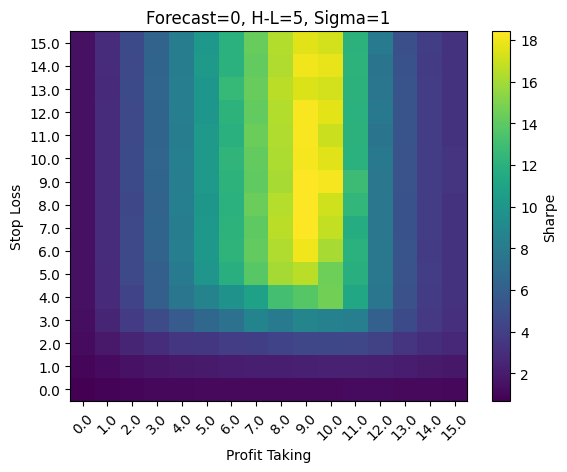

In [19]:
# Simulation code is parallelized under the hood, crawls without parallelization

n_jobs = cpu_count()

# Reflect forecast of 110 across current price of 100 to get profit taking at 90
coefficients = {"forecast": 110, "hl": 10, "sigma": 1} 
rPT = rSLm = np.linspace(0, 15, 16)

results = run_batch(coefficients, rPT, rSLm, seed=100, nIter=1e4, n_jobs=n_jobs)
results_frame = pd.DataFrame(data=results, columns=["Profit Taking", "Stop Loss", "Mean", "Std", "Sharpe"])

heatmap_frame = results_frame.pivot(index="Stop Loss", columns="Profit Taking", values="Sharpe")

plot_heatmap(heatmap_frame)

Notice that heatmap has high sharp for Profit Taking at 9 and Stop Loss at 105

### 13.6

Parallelize Snippets 13.1 and 13.2 using the mpEngine module described in
Chapter 20.

Parallelized in mc_parallel.py; see snipet below

In [11]:
import multiprocessing as mp
import numpy as np
from random import gauss
from itertools import product

def run_combination(comb_, seed, nIter, maxHP, phi, coeffs):
    output2 = []
    for iter_ in range(int(nIter)):
        p = seed
        hp = 0
        while True:
            p = (1 - phi) * coeffs['forecast'] + phi * p + coeffs['sigma'] * gauss(0, 1)
            cP = p - seed
            hp += 1
            if cP > comb_[0] or cP < -comb_[1] or hp > maxHP:
                output2.append(cP)
                break

    mean, std = np.mean(output2), np.std(output2)
    return comb_[0], comb_[1], mean, std, mean / std


def _run_combination_wrapper(args):
    return run_combination(*args)


def run_batch(coeffs, rPT, rSLm, nIter=1e5, maxHP=100, seed=0, n_jobs=4):
    phi = 2 ** (-1. / coeffs['hl'])
    combinations = list(product(rPT, rSLm))

    args = [(comb_, seed, nIter, maxHP, phi, coeffs) for comb_ in combinations]

    with mp.Pool(processes=n_jobs) as pool:
        results = list(pool.imap(_run_combination_wrapper, args))

    return results
